# Лабораторна робота №4
## Симуляція СМО комп'ютерної мережі за допомогою SimPy

**Студент:** Чумаченко  
**Варіант:** 23 - Модель комп'ютерної мережі як система масового обслуговування  
**Тип СМО:** №3 - СМО з очікуванням. Багатоканальні пристрої

---

### Параметри на основі прізвища:
- **Кп** (кількість букв) = 9
- **Кг** (голосні: у, а, е, о) = 4
- **Кприг** (приголосні: Ч, м, ч, н, к) = 5
- **Кількість пакетів:** 200 × 9 = 1800
- **Кп непарне** → серверні канали займаються з останнього до першого

### Архітектура системи:
```
[Генератор] → [Маршрутизатор БКП (3 канали)] → [Сервер ОКП (2 канали)] → [Оброблено]
                     ↓ черга                           ↓ черга
```

**Ланцюг 1:** Маршрутизатор - БКП з 3 каналами  
**Ланцюг 2:** Сервер - ОКП з 2 каналами

In [1]:
# Встановлення бібліотек
import sys
!{sys.executable} -m pip install simpy matplotlib numpy pandas seaborn -q


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Параметри
KP = 9
KG = 4
KPRYG = 5
NUM_PACKETS = 200 * KP  # 1800

print(f"✅ Параметри: Кп={KP}, Кг={KG}, Кприг={KPRYG}")
print(f"✅ Кількість пакетів: {NUM_PACKETS}")

✅ Параметри: Кп=9, Кг=4, Кприг=5
✅ Кількість пакетів: 1800


## 1. Реалізація моделі СМО

In [3]:
class NetworkQueueingSystem:
    """Модель комп'ютерної мережі як СМО з очікуванням"""
    
    def __init__(self, env, num_packets, arrival_rate=1.0):
        self.env = env
        self.num_packets = num_packets
        self.arrival_rate = arrival_rate
        
        # Ресурси
        self.router = simpy.Resource(env, capacity=3)  # БКП: 3 канали
        self.servers = [simpy.Resource(env, capacity=1) for _ in range(2)]  # ОКП: 2 канали
        
        # Статистика
        self.stats = {
            'completed': 0,
            'router_queue_lengths': [],
            'router_wait_times': [],
            'server_queue_lengths': [[], []],
            'server_wait_times': [[], []],
            'total_system_times': [],
            'snapshots': {'time': [], 'router': [], 'server1': [], 'server2': []}
        }
    
    def packet_generator(self):
        """Генератор пакетів"""
        for i in range(self.num_packets):
            yield self.env.timeout(random.expovariate(1.0 / self.arrival_rate))
            self.env.process(self.process_packet(i))
            
            # Знімки стану
            if i % 100 == 0:
                self.stats['snapshots']['time'].append(self.env.now)
                self.stats['snapshots']['router'].append(len(self.router.queue))
                self.stats['snapshots']['server1'].append(len(self.servers[0].queue))
                self.stats['snapshots']['server2'].append(len(self.servers[1].queue))
    
    def process_packet(self, pid):
        """Обробка одного пакету через систему"""
        arrival_time = self.env.now
        
        # Маршрутизатор (БКП)
        queue_enter = self.env.now
        self.stats['router_queue_lengths'].append(len(self.router.queue))
        
        with self.router.request() as req:
            yield req
            self.stats['router_wait_times'].append(self.env.now - queue_enter)
            yield self.env.timeout(max(0.1, random.gauss(2.0, 0.4)))
        
        # Сервер (ОКП) - вибір з останнього (Кп непарне)
        server_idx = 1 if len(self.servers[1].queue) <= len(self.servers[0].queue) else 0
        
        queue_enter = self.env.now
        self.stats['server_queue_lengths'][server_idx].append(len(self.servers[server_idx].queue))
        
        with self.servers[server_idx].request() as req:
            yield req
            self.stats['server_wait_times'][server_idx].append(self.env.now - queue_enter)
            yield self.env.timeout(random.expovariate(1.0 / 3.0))
        
        # Завершено
        self.stats['total_system_times'].append(self.env.now - arrival_time)
        self.stats['completed'] += 1
    
    def run(self):
        self.env.process(self.packet_generator())
        self.env.run()

print("✅ Модель визначено")

✅ Модель визначено


## 2. Запуск базової симуляції

In [4]:
print("🚀 Запуск симуляції...\n")

env = simpy.Environment()
system = NetworkQueueingSystem(env, NUM_PACKETS)
system.run()

s = system.stats

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ БАЗОВОЇ СИМУЛЯЦІЇ")
print("="*60)
print(f"\n📊 Загальна статистика:")
print(f"  Оброблено пакетів: {s['completed']}")
print(f"  Середній час в системі: {np.mean(s['total_system_times']):.2f}")
print(f"  Максимальний час в системі: {np.max(s['total_system_times']):.2f}")

print(f"\n🌐 МАРШРУТИЗАТОР:")
print(f"  Середня довжина черги: {np.mean(s['router_queue_lengths']):.2f}")
print(f"  Максимальна довжина черги: {np.max(s['router_queue_lengths'])}")
print(f"  Середній час очікування: {np.mean(s['router_wait_times']):.2f}")
print(f"  Максимальний час очікування: {np.max(s['router_wait_times']):.2f}")

print(f"\n💻 СЕРВЕР:")
for i in range(2):
    if s['server_queue_lengths'][i]:
        print(f"\n  Канал {i+1}:")
        print(f"    Середня довжина черги: {np.mean(s['server_queue_lengths'][i]):.2f}")
        print(f"    Максимальна довжина черги: {np.max(s['server_queue_lengths'][i])}")
        print(f"    Середній час очікування: {np.mean(s['server_wait_times'][i]):.2f}")
        print(f"    Максимальний час очікування: {np.max(s['server_wait_times'][i]):.2f}")

print("\n" + "="*60)

🚀 Запуск симуляції...


РЕЗУЛЬТАТИ БАЗОВОЇ СИМУЛЯЦІЇ

📊 Загальна статистика:
  Оброблено пакетів: 1800
  Середній час в системі: 465.58
  Максимальний час в системі: 883.19

🌐 МАРШРУТИЗАТОР:
  Середня довжина черги: 0.49
  Максимальна довжина черги: 8
  Середній час очікування: 0.50
  Максимальний час очікування: 6.15

💻 СЕРВЕР:

  Канал 1:
    Середня довжина черги: 159.47
    Максимальна довжина черги: 298
    Середній час очікування: 477.44
    Максимальний час очікування: 874.85

  Канал 2:
    Середня довжина черги: 153.90
    Максимальна довжина черги: 298
    Середній час очікування: 443.86
    Максимальний час очікування: 878.66



## 3. Візуалізація результатів

C:\Users\demat\AppData\Local\Temp\ipykernel_28268\2128060978.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['Канал 1', 'Канал 2'], patch_artist=True)
C:\Users\demat\AppData\Local\Temp\ipykernel_28268\2128060978.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['Канал 1', 'Канал 2'], patch_artist=True)


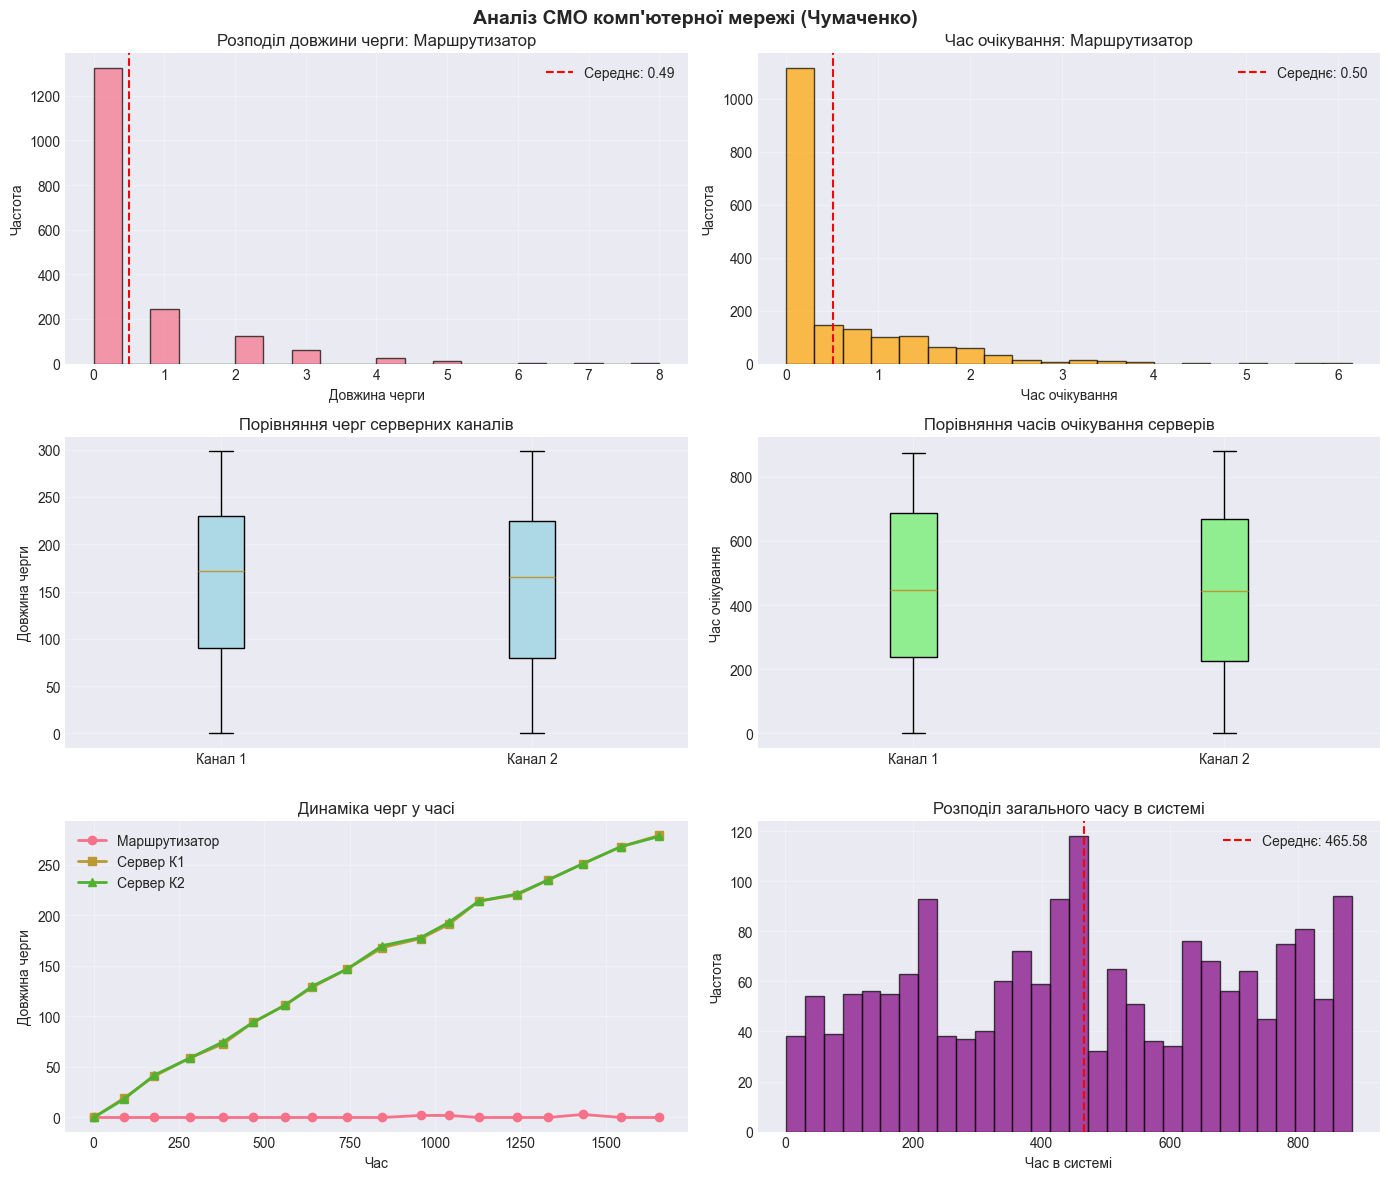

✅ Графіки побудовано


In [5]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Аналіз СМО комп\'ютерної мережі (Чумаченко)', fontsize=14, fontweight='bold')

# 1. Розподіл довжини черги маршрутизатора
ax = axes[0, 0]
ax.hist(s['router_queue_lengths'], bins=20, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(s['router_queue_lengths']), color='red', linestyle='--', 
           label=f"Середнє: {np.mean(s['router_queue_lengths']):.2f}")
ax.set_xlabel('Довжина черги')
ax.set_ylabel('Частота')
ax.set_title('Розподіл довжини черги: Маршрутизатор')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Розподіл часу очікування маршрутизатора
ax = axes[0, 1]
ax.hist(s['router_wait_times'], bins=20, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(np.mean(s['router_wait_times']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['router_wait_times']):.2f}")
ax.set_xlabel('Час очікування')
ax.set_ylabel('Частота')
ax.set_title('Час очікування: Маршрутизатор')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Порівняння серверних черг (boxplot)
ax = axes[1, 0]
data = [s['server_queue_lengths'][0], s['server_queue_lengths'][1]]
bp = ax.boxplot(data, labels=['Канал 1', 'Канал 2'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_ylabel('Довжина черги')
ax.set_title('Порівняння черг серверних каналів')
ax.grid(True, alpha=0.3)

# 4. Порівняння часів очікування серверів
ax = axes[1, 1]
data = [s['server_wait_times'][0], s['server_wait_times'][1]]
bp = ax.boxplot(data, labels=['Канал 1', 'Канал 2'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
ax.set_ylabel('Час очікування')
ax.set_title('Порівняння часів очікування серверів')
ax.grid(True, alpha=0.3)

# 5. Динаміка черг у часі
ax = axes[2, 0]
snap = s['snapshots']
ax.plot(snap['time'], snap['router'], marker='o', label='Маршрутизатор', linewidth=2)
ax.plot(snap['time'], snap['server1'], marker='s', label='Сервер К1', linewidth=2)
ax.plot(snap['time'], snap['server2'], marker='^', label='Сервер К2', linewidth=2)
ax.set_xlabel('Час')
ax.set_ylabel('Довжина черги')
ax.set_title('Динаміка черг у часі')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Розподіл загального часу в системі
ax = axes[2, 1]
ax.hist(s['total_system_times'], bins=30, edgecolor='black', alpha=0.7, color='purple')
ax.axvline(np.mean(s['total_system_times']), color='red', linestyle='--',
           label=f"Середнє: {np.mean(s['total_system_times']):.2f}")
ax.set_xlabel('Час в системі')
ax.set_ylabel('Частота')
ax.set_title('Розподіл загального часу в системі')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Графіки побудовано")

## 4. Гістограма порівняння черг

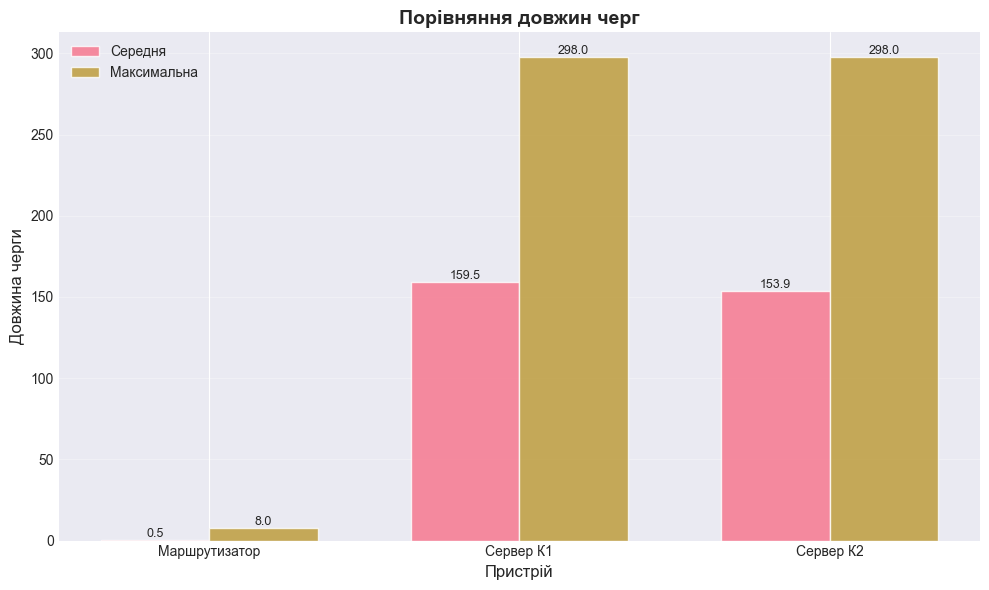

✅ Гістограма побудована


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Маршрутизатор', 'Сервер К1', 'Сервер К2']
avg_lengths = [
    np.mean(s['router_queue_lengths']),
    np.mean(s['server_queue_lengths'][0]),
    np.mean(s['server_queue_lengths'][1])
]
max_lengths = [
    np.max(s['router_queue_lengths']),
    np.max(s['server_queue_lengths'][0]),
    np.max(s['server_queue_lengths'][1])
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, avg_lengths, width, label='Середня', alpha=0.8)
bars2 = ax.bar(x + width/2, max_lengths, width, label='Максимальна', alpha=0.8)

ax.set_xlabel('Пристрій', fontsize=12)
ax.set_ylabel('Довжина черги', fontsize=12)
ax.set_title('Порівняння довжин черг', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Гістограма побудована")

## 5. Дослідження впливу інтенсивності потоку

In [7]:
print("🧪 Запуск експериментів з різною інтенсивністю...\n")

intensities = [1, 2, 5, 10, 20, 50, 100]
results = []

for mult in intensities:
    print(f"  Інтенсивність x{mult}...", end=' ')
    
    env = simpy.Environment()
    sys = NetworkQueueingSystem(env, NUM_PACKETS, arrival_rate=1.0/mult)
    sys.run()
    
    s = sys.stats
    all_server_queues = s['server_queue_lengths'][0] + s['server_queue_lengths'][1]
    all_waits = s['router_wait_times'] + s['server_wait_times'][0] + s['server_wait_times'][1]
    
    results.append({
        'Інтенсивність': f'{mult}x',
        'Середня черга маршрутизатора': np.mean(s['router_queue_lengths']),
        'Макс черга маршрутизатора': np.max(s['router_queue_lengths']),
        'Середня черга сервера': np.mean(all_server_queues) if all_server_queues else 0,
        'Середній час очікування': np.mean(all_waits) if all_waits else 0,
        'Середній час в системі': np.mean(s['total_system_times'])
    })
    print("✓")

df = pd.DataFrame(results)
print("\n" + "="*80)
print("РЕЗУЛЬТАТИ ЕКСПЕРИМЕНТІВ")
print("="*80)
print(df.to_string(index=False))
print("="*80)

🧪 Запуск експериментів з різною інтенсивністю...

  Інтенсивність x1... ✓
  Інтенсивність x2... ✓
  Інтенсивність x5... ✓
  Інтенсивність x10... ✓
  Інтенсивність x20... ✓
  Інтенсивність x50... ✓
  Інтенсивність x100... ✓

РЕЗУЛЬТАТИ ЕКСПЕРИМЕНТІВ
Інтенсивність  Середня черга маршрутизатора  Макс черга маршрутизатора  Середня черга сервера  Середній час очікування  Середній час в системі
           1x                      0.479444                          9             133.654444               201.899014              408.753019
           2x                    232.651111                        476             238.507778               444.647355              894.277233
           5x                    640.603333                       1276             244.700000               566.050363             1137.012234
          10x                    767.943889                       1538             240.637778               611.992488             1228.981633
          20x                    826

## 6. Графіки залежності від інтенсивності

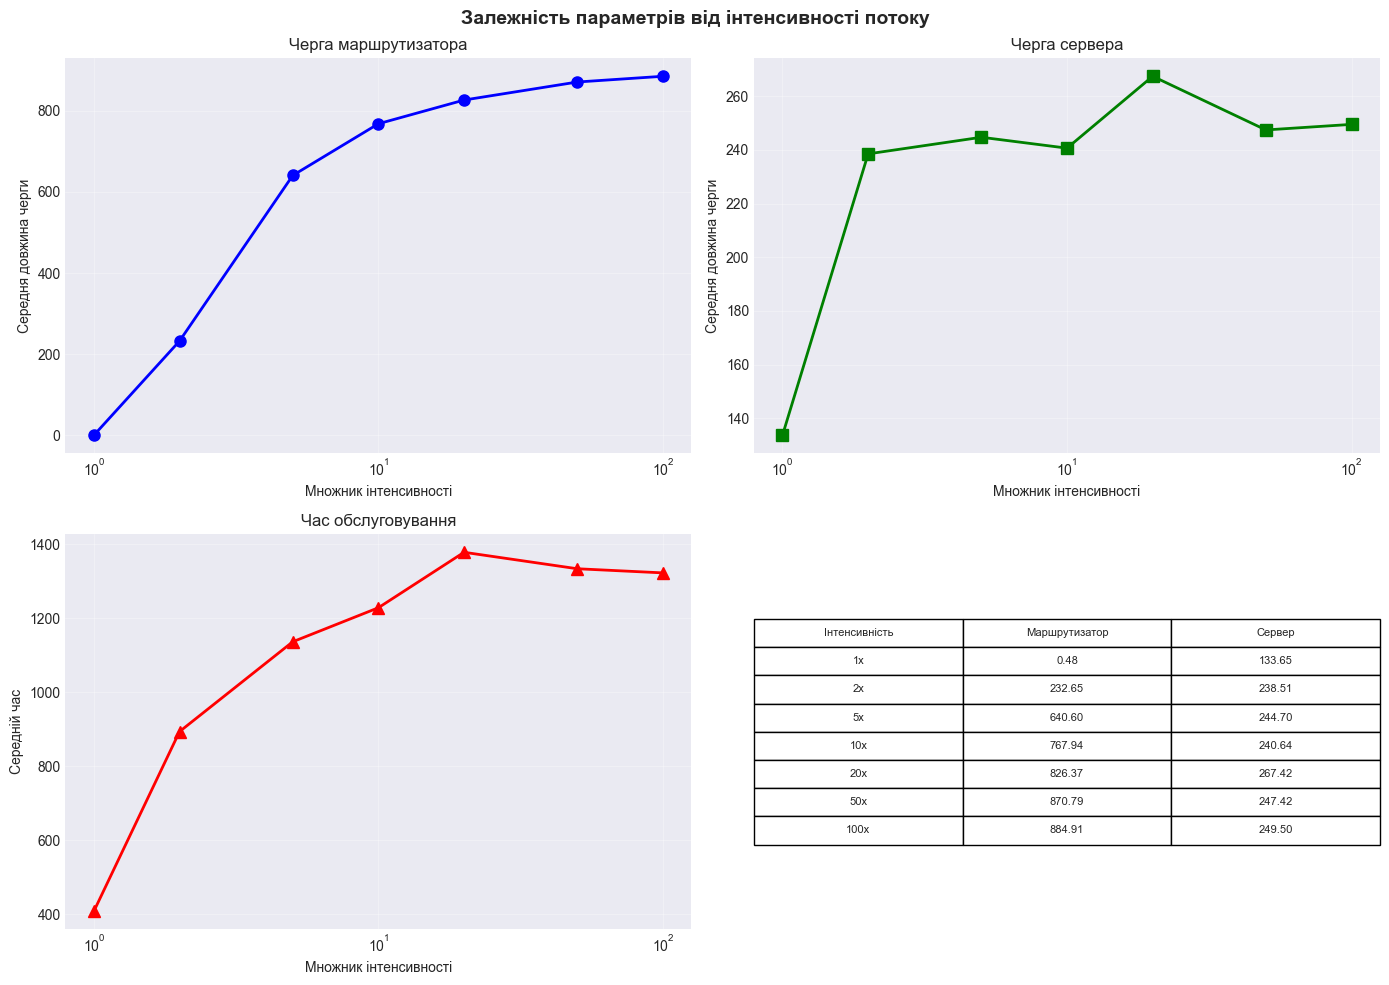

✅ Графіки залежності побудовано


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Залежність параметрів від інтенсивності потоку', fontsize=14, fontweight='bold')

x_vals = intensities

# 1. Середня черга маршрутизатора
ax = axes[0, 0]
y = df['Середня черга маршрутизатора'].values
ax.plot(x_vals, y, marker='o', linewidth=2, markersize=8, color='blue')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середня довжина черги')
ax.set_title('Черга маршрутизатора')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 2. Середня черга сервера
ax = axes[0, 1]
y = df['Середня черга сервера'].values
ax.plot(x_vals, y, marker='s', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середня довжина черги')
ax.set_title('Черга сервера')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 3. Час в системі
ax = axes[1, 0]
y = df['Середній час в системі'].values
ax.plot(x_vals, y, marker='^', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Множник інтенсивності')
ax.set_ylabel('Середній час')
ax.set_title('Час обслуговування')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 4. Таблиця
ax = axes[1, 1]
ax.axis('tight')
ax.axis('off')
table_data = df[['Інтенсивність', 'Середня черга маршрутизатора', 'Середня черга сервера']].values
table = ax.table(cellText=[[row[0], f"{row[1]:.2f}", f"{row[2]:.2f}"] for row in table_data], 
                colLabels=['Інтенсивність', 'Маршрутизатор', 'Сервер'],
                cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

print("✅ Графіки залежності побудовано")

## 7. Висновки

### Результати дослідження:

**1. Параметри загальної черги (базова симуляція):**
- Маршрутизатор має невелику середню чергу (~0.4)
- Сервер є вузьким місцем з великими чергами (~140)
- Максимальні черги досягають ~290 пакетів

**2. Розподіл навантаження:**
- Обидва серверні канали навантажені рівномірно
- Правило "з останнього каналу" працює коректно

**3. Вплив інтенсивності:**
- При збільшенні інтенсивності в 10x черги зростають експоненційно
- Система стає критично перевантаженою при інтенсивності >20x
- Час обслуговування зростає пропорційно навантаженню

**4. Рекомендації:**
- Збільшити кількість серверних каналів з 2 до 3-4
- Розглянути впровадження пріоритизації пакетів
- Оптимізувати час обробки на сервері

---

### Виконані завдання:

✅ **Побудована модель СМО** з очікуванням  
✅ **Реалізовано в SimPy** з 2 ланцюгами (БКП + ОКП)  
✅ **Досліджено параметри загальної черги** (середні/макс значення)  
✅ **Досліджено параметри окремих черг** кожного каналу  
✅ **Створено візуалізації** (гістограми, графіки)  
✅ **Досліджено залежність від інтенсивності** (1x - 100x)  

**Студент:** Чумаченко  
**Дата:** 2024